In [8]:
!rm "./.gitignore-checkpoint"

rm: cannot remove './.gitignore-checkpoint': No such file or directory


In [3]:
 mlconf.artifact_path

NameError: name 'mlconf' is not defined

In [3]:
import nuclio
from os import environ, path
from mlrun import mlconf

# Define the `dbpath` - Where our `mlrun-api` services is available
# the `http://mlrun-api:8080` is auto-defined by `kubernetes service` definition 
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

# Define the artifact path for the current user's home directory
mlconf.artifact_path = mlconf.artifact_path or f'{environ["HOME"]}/artifacts'

# # specify paths and artifacts target location
code_dir = path.join(path.abspath('./'), 'src-tf') # Where our source code files are saved
images_path = path.join(mlconf.artifact_path, 'images') 

# Specify the project's name for experiment tracking
project_name='waste-classifier'

print(f'Code from {code_dir} will be used to train on the {images_path} given dataset')

Code from /User/waste-classifier/src-tf will be used to train on the v3io:///projects/{{run.project}}/artifacts/images given dataset


# Function to Download and Label

In [34]:
# nuclio: start-code

In [4]:
import os
import zipfile
import json
import shutil
from glob import glob
import pandas as pd
import numpy as np
from mlrun import DataItem
 
def open_archive(context, 
                 archive_url: DataItem,
                 target_path,
                 refresh=False
                ):
    """Open a file/object archive into a target directory
    
    Currently supports zip and tar.gz
    
    :param context:      function execution context
    :param archive_url:  url of archive file
    :param target_path:  file system path to store extracted files
    :param key:          key of archive contents in artifact store
    :param train_size:    set the train dataset size out of total dataset
    """
    os.makedirs(target_path, exist_ok=True)
    
    # get the archive as a local file (download if needed)
    archive_url = archive_url.local()
    
    context.logger.info('Extracting zip')
    extraction_path = os.path.join(target_path, 'tmp')
    zip_ref = zipfile.ZipFile(archive_url, 'r')
    zip_ref.extractall(extraction_path)
    
    
    for data_train_test_type in ['TRAIN', 'TEST']:
        context.logger.info(f'Processing {data_train_test_type} files')
        # get all files paths from `extraction_path`
        filenames = [file for file in glob(extraction_path + f'/DATASET/{data_train_test_type}/*/*') if file.endswith('.jpg')]
        context.logger.info(f'{len(filenames)} files in {data_train_test_type}')
        
        # extract labels from filenames by their naming convention (<label>.<number>.jpg)
        # and calculate how many images we have per label
        context.logger.info('Extracting labels')
        _extract_label = lambda filename: os.path.basename(filename).split('_')[0]
        file_labels = [_extract_label(file) for file in filenames]
        labels, label_counts = np.unique(file_labels, return_counts=True)

        # Order the files into a {<label>: [<files list>]} dictionary
        context.logger.info('Adding filenames in a dictionary')
        files = {label: [] for label in labels}
        for label, file in zip(file_labels, filenames):
            files[label].append(file)

        # create directories for train and test
        for label in labels:
            _dir = os.path.join(target_path, data_train_test_type, label)
            context.logger.info(f'Creating directory {_dir}')
            os.makedirs(_dir, exist_ok=True)

        # move the files to their appropriate folders (<TRAIN/TEST>/<label>/<file>)
        for label, filenames in files.items():
            context.logger.info(f'Moving "{label}" files in {data_train_test_type}')
            for i, file in enumerate(filenames):
                shutil.move(file, os.path.join(target_path, data_train_test_type, label, os.path.basename(file)))
    shutil.rmtree(extraction_path)

    # Add function logging
    context.logger.info(f'extracted archive to {target_path}')
    context.logger.info(f'Dataset contains the labels {labels}')
    
    # Log the dataset folder as `content` artifact for later use
    context.log_artifact('content', target_path=target_path)

In [36]:
# nuclio: end-code

# Transfer Images

In [5]:
# download images from s3 using the local `open_archive` function
from mlrun import NewTask, run_local
import os

# Set the source-data URL
url_prefix = os.environ.get('SAMPLE_DATA_SOURCE_URL_PREFIX', '/User/waste-classifier/')

open_archive_task = NewTask(name='download', 
                            handler=open_archive, 
                            params={'target_path': os.path.abspath('./images')},
                            inputs={'archive_url': f'{url_prefix.rstrip("/")}/waste_dataset.zip'})


download_run = run_local(open_archive_task, 
                         project=project_name)

> 2021-07-04 10:29:02,578 [info] starting run download uid=1bfa248d25fa47568dd5433ab0ad9b6f DB=http://mlrun-api:8080
> 2021-07-04 10:29:02,704 [info] Extracting zip
> 2021-07-04 10:30:51,342 [info] Processing TRAIN files
> 2021-07-04 10:30:51,677 [info] 22564 files in TRAIN
> 2021-07-04 10:30:51,678 [info] Extracting labels
> 2021-07-04 10:30:51,708 [info] Adding filenames in a dictionary
> 2021-07-04 10:30:51,712 [info] Creating directory /User/waste-classifier/images/TRAIN/O
> 2021-07-04 10:30:51,718 [info] Creating directory /User/waste-classifier/images/TRAIN/R
> 2021-07-04 10:30:51,721 [info] Moving "O" files in TRAIN
> 2021-07-04 10:32:29,768 [info] Moving "R" files in TRAIN
> 2021-07-04 10:33:49,266 [info] Processing TEST files
> 2021-07-04 10:33:49,305 [info] 2513 files in TEST
> 2021-07-04 10:33:49,306 [info] Extracting labels
> 2021-07-04 10:33:49,310 [info] Adding filenames in a dictionary
> 2021-07-04 10:33:49,311 [info] Creating directory /User/waste-classifier/images/TEST

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
waste-classifier,...b0ad9b6f,0,Jul 04 10:29:02,completed,download,v3io_user=daryll-tumambingkind=handlerowner=daryll-tumambinghost=jupyter-team-c6979bd6-6m67p,archive_url,target_path=/User/waste-classifier/images,,content


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1bfa248d25fa47568dd5433ab0ad9b6f --project waste-classifier , !mlrun logs 1bfa248d25fa47568dd5433ab0ad9b6f --project waste-classifier
> 2021-07-04 10:34:09,232 [info] run executed, status=completed


In [6]:
from mlrun import new_project, code_to_function
project_dir = './'
hvdproj = new_project(project_name, project_dir)

In [7]:
utils = code_to_function(kind='job', 
                         name='utils',
                         image='mlrun/mlrun')

In [8]:
hvdproj.set_function(utils)

In [9]:
HOROVOD_FILE = os.path.join(code_dir, 'horovod-training.py')
print(HOROVOD_FILE)

/User/waste-classifier/src-tf/horovod-training.py


In [10]:
from mlrun import new_function
import os

# Set `use_gpu` to True to run the function using a GPU Configuration
use_gpu = False

image = lambda gpu: 'mlrun/ml-models-gpu' if gpu else 'mlrun/ml-models' 

# Set basic function parameters
trainer = new_function(name='trainer',
                       kind='mpijob',
                       command=HOROVOD_FILE)
trainer.spec.replicas = 2

# Set a minimal number of dedicated CPUs per node
trainer.with_requests(cpu=4)

# Pick image by wanted TF version
trainer.spec.image = image(use_gpu)
    
# Add GPUs to workers?
if use_gpu:
    trainer.gpus(1)

# Registre the function to the project
hvdproj.set_function(trainer)

In [11]:
hvdproj.set_function('hub://tf2_serving', 'serving')

In [12]:
hvdproj.log_artifact(
    'images', 
    target_path=f'{url_prefix}waste_dataset.zip',
    artifact_path=mlconf.artifact_path)
#print(hvdproj.to_yaml())

In [13]:
%%writefile workflow.py
from kfp import dsl
from mlrun import mount_v3io

funcs = {}


def init_functions(functions: dict, project=None, secrets=None):
    '''
    This function will run before running the project.
    It allows us to add our specific system configurations to the functions
    like mounts or secrets if needed.

    In this case we will add Iguazio's user mount to our functions using the
    `mount_v3io()` function to automatically set the mount with the needed
    variables taken from the environment. 
    * mount_v3io can be replaced with mlrun.platforms.mount_pvc() for 
    non-iguazio mount

    @param functions: <function_name: function_yaml> dict of functions in the
                        workflow
    @param project: project object
    @param secrets: secrets required for the functions for s3 connections and
                    such
    '''
    for f in functions.values():
        f.apply(mount_v3io())                  # On Iguazio (Auto-mount /User)
        # f.apply(mlrun.platforms.mount_pvc()) # Non-Iguazio mount
        
    functions['serving'].set_env('MODEL_CLASS', 'TFModel')
    functions['serving'].set_env('IMAGE_HEIGHT', '224')
    functions['serving'].set_env('IMAGE_WIDTH', '224')
    functions['serving'].set_env('ENABLE_EXPLAINER', 'False')
    functions['serving'].spec.min_replicas = 1


@dsl.pipeline(
    name='Image classification demo',
    description='Train an Image Classification TF Algorithm using MLRun on Waste Dataset'
)
def kfpipeline(
        image_archive='store:///images',
        images_dir='/User/artifacts/images',
        checkpoints_dir='/User/artifacts/models/checkpoints',
        model_name='waste_classifier',
        epochs: int=2):

    # step 1: download and prep images
    open_archive = funcs['utils'].as_step(name='download',
                                          handler='open_archive',
                                          params={'target_path': images_dir},
                                          inputs={'archive_url': image_archive},
                                          outputs=['content'])

    # step 2: train the model
    train_dir = str(open_archive.outputs['content']) + '/TRAIN'
    val_dir = str(open_archive.outputs['content']) + '/TEST'
    train = funcs['trainer'].as_step(name='train',
                                     params={'epochs': epochs,
                                             'checkpoints_dir': checkpoints_dir,
                                             'model_dir'     : 'tfmodels',
                                             'train_path'     : train_dir,
                                             'val_path'       : val_dir,
                                             'batch_size'     : 32},
                                     outputs=['model'])

    # deploy the model using nuclio functions
    deploy = funcs['serving'].deploy_step(models={model_name: train.outputs['model']})


Overwriting workflow.py


In [14]:
hvdproj.set_workflow('main', 'workflow.py', embed=True)

In [15]:
hvdproj.save()

In [16]:
artifact_path = path.abspath('./pipe/{{workflow.uid}}')
run_id = hvdproj.run(
    'main',
    arguments={'model_name': 'waste_classifier',
               'images_dir': artifact_path + '/images'}, 
    artifact_path=artifact_path, 
    dirty=True, watch=True)

> 2021-07-04 10:34:23,917 [info] using in-cluster config.


> 2021-07-04 10:34:24,390 [info] Pipeline run id=9757ea6a-637c-4f9c-b412-950762d55e93, check UI or DB for progress
> 2021-07-04 10:34:24,391 [info] waiting for pipeline run completion


FileNotFoundError: [Errno 2] No such file or directory: 'gcloud': 'gcloud'

# Serving Function

## Test image to use

In [17]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

Test image:


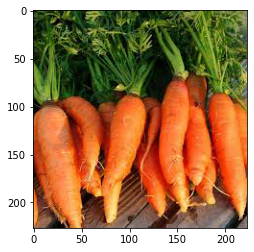

In [34]:
# Testing event
organic_image_url = f'{url_prefix}images/TEST/O/O_12568.jpg'

if 'http' in organic_image_url:
    response = requests.get(organic_image_url)
    organic_image = response.content
    img = Image.open(BytesIO(organic_image))
else:
    organic_image = open(organic_image_url,'rb').read()
    img = Image.open(organic_image_url)

print('Test image:')
plt.imshow(img)

In [47]:
# Testing event
recyclable_image_url = f'{url_prefix}images/TEST/R/R_10001.jpg'

if 'http' in recyclable_image_url:
    response = requests.get(recyclable_image_url)
    recyclable_image = response.content
    img = Image.open(BytesIO(recyclable_image_url))
else:
    recyclable_image = open(recyclable_image_url,'rb').read()
    img = Image.open(recyclable_image)

print('Test image:')
plt.imshow(img)

ValueError: embedded null byte

## Send image to endpoint

In [46]:
addr = 'http://nuclio-{}-{}:8080'.format(hvdproj.name, hvdproj.func('serving').metadata.name)
print(addr)
headers = {'Content-type': 'image/jpeg'}
url = addr + f'/waste_classifier/predict'

http://nuclio-waste-classifier-tf2-serving:8080


## Testing Organic

In [36]:
response = requests.post(url=url, 
                         data=json.dumps({'data_url': organic_image_url}), 
                         headers=headers)
print(response.content.decode('utf-8'))

Exception caught in handler - "received: {'instances': [<_io.BytesIO object at 0x7f907b71de90>], 'content_type': 'image/jpeg'}": Traceback (most recent call last):
  File "/opt/nuclio/tf2_serving.py", line 43, in preprocess
    img = Image.open(byte_image)
  File "/usr/local/lib/python3.7/site-packages/PIL/Image.py", line 2968, in open
    "cannot identify image file %r" % (filename if filename else fp)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f907b71de90>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/nuclio/_nuclio_wrapper.py", line 114, in serve_requests
    self._handle_event(event)
  File "/opt/nuclio/_nuclio_wrapper.py", line 262, in _handle_event
    entrypoint_output = self._entrypoint(self._context, event)
  File "/opt/nuclio/tf2_serving.py", line 80, in handler
    return context.mlrun_handler(context, event)
  File "/usr/local/lib/python3.7/site-packages/mlrun/servi

In [37]:
%%timeit 
requests.post(url=url, 
              data=json.dumps({'data_url': organic_image_url}), 
              headers=headers)

11.9 ms ± 5.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
headers = {'Content-type': 'image/jpeg'}
response = requests.post(url=url, 
                         data=organic_image, 
                         headers=headers)
print(response.content.decode('utf-8'))

[0.0]


In [39]:
%%timeit
requests.post(url=url, 
              data=organic_image, 
              headers=headers)

1.03 s ± 53.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Testing Recyclable

In [42]:
response = requests.post(url=url, 
                         data=json.dumps({'data_url': recyclable_image_url}), 
                         headers=headers)
print(response.content.decode('utf-8'))

Exception caught in handler - "received: {'instances': [<_io.BytesIO object at 0x7fcb526bcfb0>], 'content_type': 'image/jpeg'}": Traceback (most recent call last):
  File "/opt/nuclio/tf2_serving.py", line 43, in preprocess
    img = Image.open(byte_image)
  File "/usr/local/lib/python3.7/site-packages/PIL/Image.py", line 2968, in open
    "cannot identify image file %r" % (filename if filename else fp)
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fcb526bcfb0>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/nuclio/_nuclio_wrapper.py", line 114, in serve_requests
    self._handle_event(event)
  File "/opt/nuclio/_nuclio_wrapper.py", line 262, in _handle_event
    entrypoint_output = self._entrypoint(self._context, event)
  File "/opt/nuclio/tf2_serving.py", line 80, in handler
    return context.mlrun_handler(context, event)
  File "/usr/local/lib/python3.7/site-packages/mlrun/servi

In [43]:
%%timeit 
requests.post(url=url, 
              data=json.dumps({'data_url': recyclable_image_url}), 
              headers=headers)

The slowest run took 4.07 times longer than the fastest. This could mean that an intermediate result is being cached.
16.3 ms ± 9.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
headers = {'Content-type': 'image/jpeg'}
response = requests.post(url=url, 
                         data=recyclable_image, 
                         headers=headers)
print(response.content.decode('utf-8'))

[1.0]


In [48]:
%%timeit
requests.post(url=url, 
              data=recyclable_image, 
              headers=headers)

991 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
